## Traffic Simulation
### Nicolas Gort Freitas

In [905]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as col
import numpy as np
import scipy as sp
import pandas as pd
import time


class TrafficSimulation:

    def __init__(self, size=50, car_density=0.1 ,vmax=5, p_slow = 0):
        self.car_density = car_density
        self.size = size
        self.state = np.zeros(size,dtype=np.int64)
        self.p_slow = p_slow
        self.flow_record = []

    def initialize(self):

        self.state.fill(-1)

        random_indexes = sp.random.choice(
            range(self.size),
            size=int(round(self.car_density * self.size)),
            replace=False)
        self.state.flat[random_indexes] = 1

        if len(random_indexes) > 0:
            self.state.flat[random_indexes[0]] = 3

        self.time_step = 0
        self.changed = True  # Track whether the state changed between the
                             # previous time step and the current one

    def draw(self):
        
        C = np.array([[255,255,248],
            [235,198,83],
            [93,192,247],
            [71,108,248],
            [24,36,165],
            [0,0,108],
            [0,0,78]])
        
        cm = col.ListedColormap(C/255.0)
        
        fig, bars = plt.subplots(1, figsize=(15,7))
        bars.cla()
        bars.pcolor(sim.state.reshape(1,sim.state.shape[0]),vmin = -1, vmax = 5, cmap = cm)# plt.cm.binary)
        bars.axis('image')
        bars.get_yaxis().set_visible(False)
        bars.set_xticks(range(0,sim.state.shape[0]+1,2))
        bars.set_title('t = ' + str(self.time_step)) 
        
        if self.time_step == 0:
            cbaxes = fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(bars.pcolor(sim.state.reshape(1,sim.state.shape[0]),vmin = -1, vmax = 5, cmap = cm)# plt.cm.binary)
            , cax = cbaxes, orientation = 'horizontal')  

        fig.subplots_adjust(left=0)
        fig.show()    
    
    def update_middle(self): #beta
       
        self.time_step += 1

        next_state = -1*np.ones(self.state.shape,dtype=np.int64)
        #post_state = np.zeros(20,dtype=np.int64)
        # Empty cells stay empty
        
        self.flow_map = np.zeros(self.state.shape,dtype=np.int64)
        
        cars = np.where(self.state >= 0)[0]
        print 'cars %d: %d'%(self.time_step,len(cars))
        
        prev_car = [cars[(i-1)%len(cars)] for i in range(len(cars))]
        
        next_car = [cars[(i+1)%len(cars)] for i in range(len(cars))]
        print 'prev cars: '+str(prev_car) 
        print 'cars: '+str(cars)
        print 'next cars: '+str(next_car) 
        
                
        def car_distance(x,y):
            if y > x: return y - x
            else: return self.state.shape + (y - x)

        for i,car in enumerate(cars):
            
            if car_distance(car, next_car[i]) > self.state[car] + 1:
                min(car_distance(car, next_car[i]) - 1, 1)
            elif car > (prev_car[i] + next_car[i])/2 and self.state[car] > 0:
                self.state[car]-=1
            elif car < (prev_car[i] + next_car[i])/2 and self.state[car] < 5:
                self.state[car]+=1
                
        for i in cars[np.where(self.state[cars]>0)]: #only slow down cars that are actually running
            if np.random.random() < self.p_slow:
                self.state[i] -=1
        
#         print('After randomization (t=%d): '%t)
#         print self.state      
                
        
        for x in cars: 
            #at the new position (x+v), assign the updated velocity
            next_state[(x + self.state[x])%self.state.shape[0]] = self.state[x]
            if self.state[x] > 0:
                for s in range(x,(x + self.state[x])%self.state.shape[0]):
                    self.flow_map[s] = 1
        
#         print 'Positions updated (t=%d):'%t
#         print('\033[94m' + str(next_state)+ '\x1b[0m')
        #print next_state
        self.flow_record.append(np.mean(self.flow_map))
        self.state = next_state
    
    def update(self):
        self.time_step += 1

        next_state = -1*np.ones(self.state.shape,dtype=np.int64)
        #post_state = np.zeros(20,dtype=np.int64)
        # Empty cells stay empty
        
        self.flow_map = np.zeros(self.state.shape,dtype=np.int64)
        
        cars = np.where(self.state >= 0)[0]
#         print 'cars %d: %d'%(self.time_step,len(cars))
        next_car = [cars[(i+1)%len(cars)] for i in range(len(cars))]
        #print 'next cars: '+str(next_car) 
                
        def car_distance(x,y):
            if y > x: return y - x
            else: return self.state.shape + (y - x)

        for i,car in enumerate(cars):
            if self.state[car] < vmax and car_distance(car, next_car[i]) > self.state[car] + 1:
                self.state[car] += 1
            else: self.state[car] = min(car_distance(car, next_car[i]) - 1, self.state[car])
#         print 'Speeds updated (t=%d):'%t
#         print self.state
        for i in cars[np.where(self.state[cars]>0)]: #only slow down cars that are actually running
            if np.random.random() < self.p_slow:
                self.state[i] -=1
        
#         print('After randomization (t=%d): '%t)
#         print self.state      
                
        
        for x in cars: 
            #at the new position (x+v), assign the updated velocity
            next_state[(x + self.state[x])%self.state.shape[0]] = self.state[x]
            if self.state[x] > 0:
                for s in range(x,(x + self.state[x])%self.state.shape[0]):
                    self.flow_map[s] = 1
        
#         print 'Positions updated (t=%d):'%t
#         print('\033[94m' + str(next_state)+ '\x1b[0m')
        #print next_state
        self.flow_record.append(np.mean(self.flow_map))
        self.state = next_state

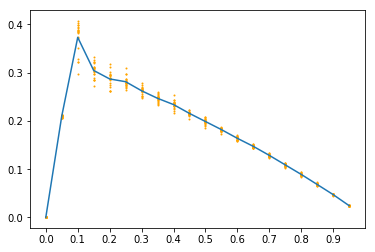

In [892]:
sim = TrafficSimulation(size=100,car_density=0.15, p_slow = 0.25)
sim.initialize()
# sim.state = np.array([1, 1, 3, -1, 1, 1, 1, -1, 1, 1])
# print 'Initial states:'
# print('\033[94m' + str(sim.state)+ '\x1b[0m')

#sim.draw()

flow = []
densities = np.array([x*np.ones(20) for x in np.arange(0,1,0.05)]).ravel()

for d in densities:
    sim = TrafficSimulation(size=100,car_density=d, p_slow = 0.5)
    sim.initialize()
    for t in range(200):
        sim.update()
    flow.append(np.mean(sim.flow_record))

density_value, average_flow = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(densities, flow) if xVal==a])) for xVal in set(densities)))
    
plt.plot(density_value,average_flow)
plt.scatter(densities,flow,c='orange',s=1)
plt.xticks(np.arange(0,1,0.1))
plt.show()
#print(pd.DataFrame((sim.state.reshape(-1,len(sim.state)))))

In [907]:
# sim = TrafficSimulation(size=100,car_density=0.15, p_slow = 0.25)
# sim.initialize()
# for t in range(20):
#         sim.update_middle()
#         sim.draw()

In [908]:
# sim = TrafficSimulation(size=100,car_density=0.15, p_slow = 0.25)
# sim.initialize()
# # sim.state = np.array([1, 1, 3, -1, 1, 1, 1, -1, 1, 1])
# # print 'Initial states:'
# # print('\033[94m' + str(sim.state)+ '\x1b[0m')

# sim.draw()

# flow = []
# densities = np.array([x*np.ones(20) for x in np.arange(0,1,0.05)]).ravel()

# for d in densities:
#     sim = TrafficSimulation(size=100,car_density=d, p_slow = 0.5)
#     sim.initialize()
#     for t in range(200):
#         sim.update()
#         sim.draw()
#     flow.append(np.mean(sim.flow_record))

# density_value, average_flow = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(densities, flow) if xVal==a])) for xVal in set(densities)))
    
# plt.plot(density_value,average_flow)
# plt.scatter(densities,flow,c='orange',s=1)
# plt.xticks(np.arange(0,1,0.1))
# plt.show()
# #print(pd.DataFrame((sim.state.reshape(-1,len(sim.state)))))

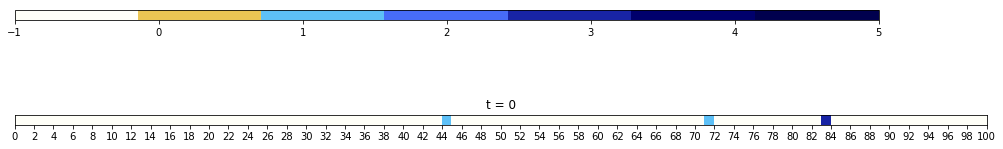

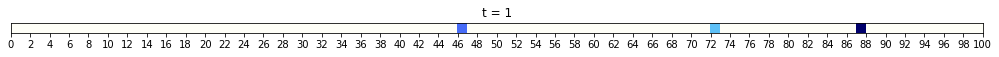

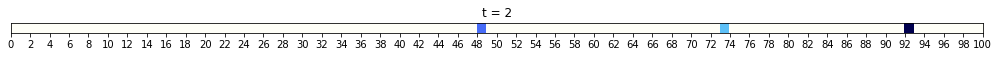

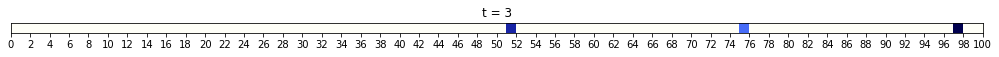

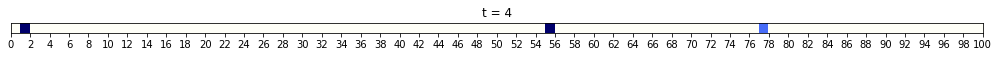

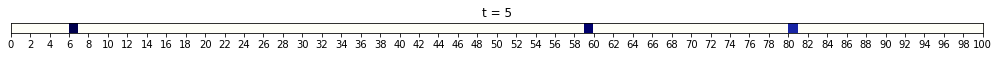

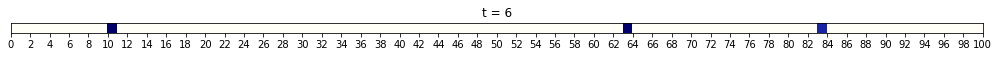

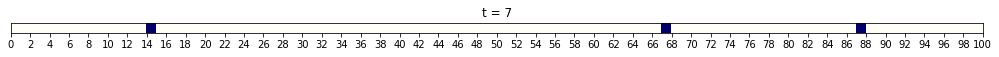

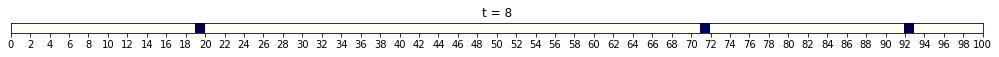

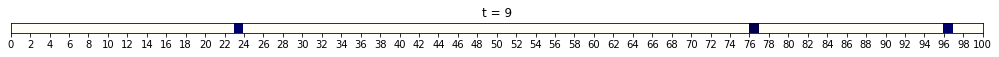

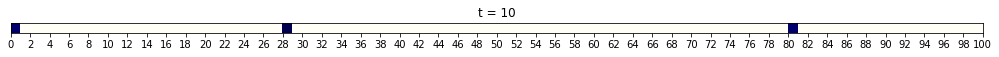

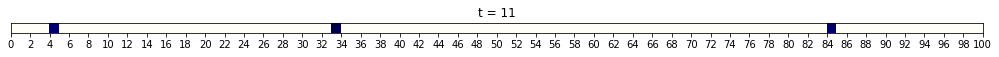

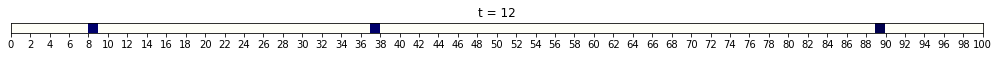

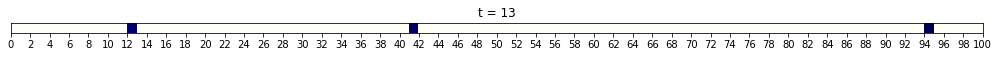

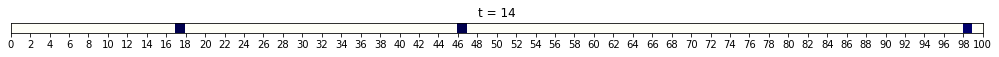

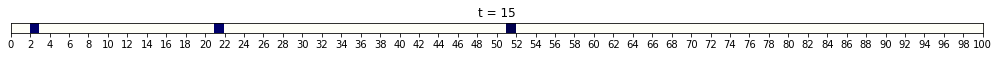

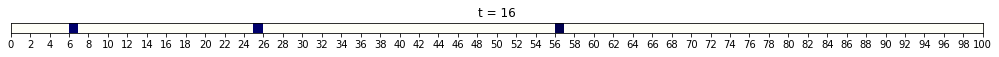

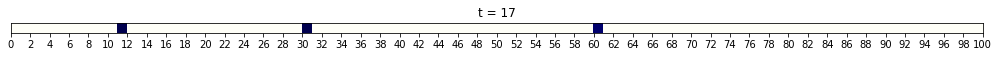

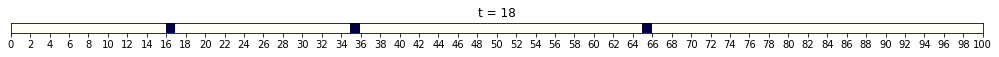

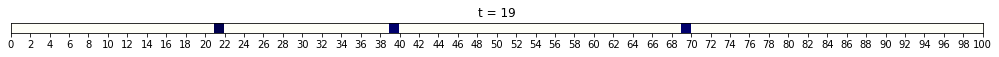

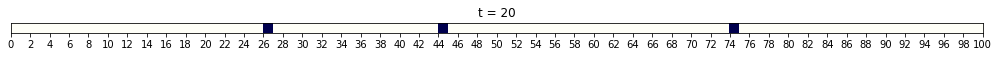

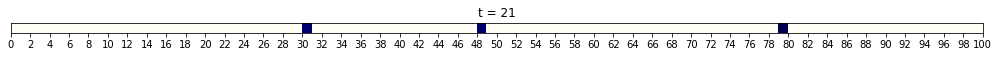

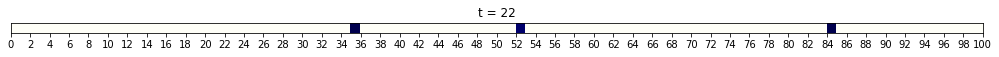

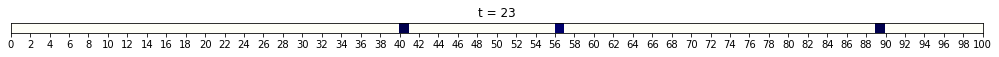

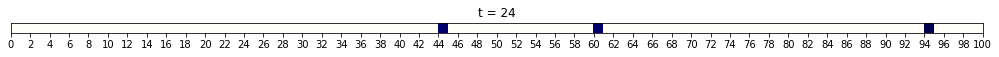

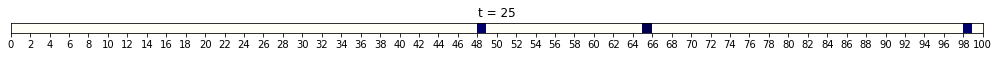

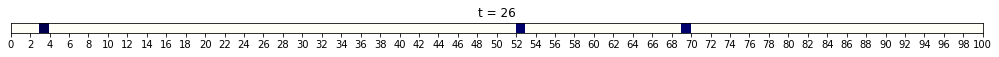

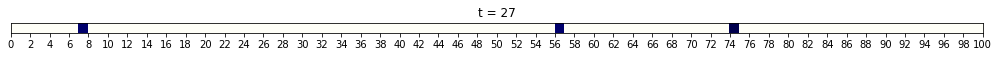

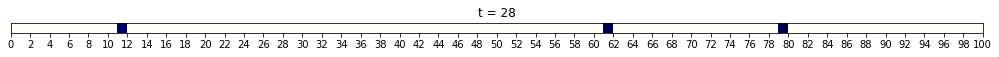

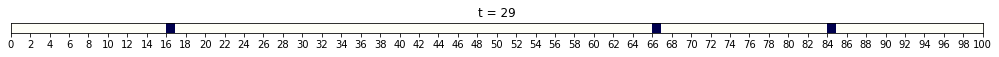

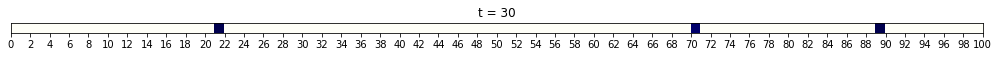

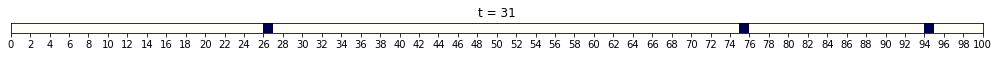

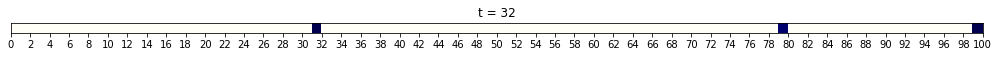

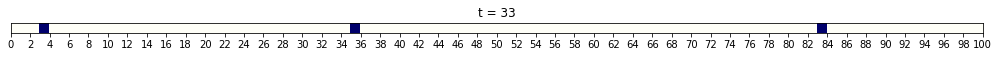

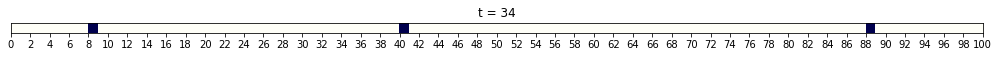

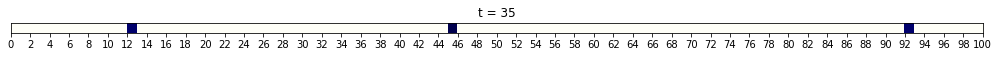

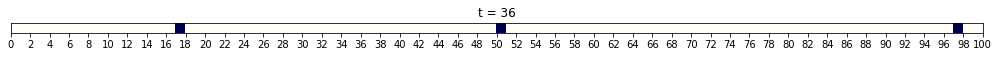

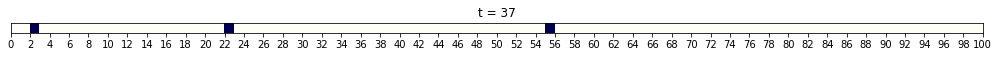

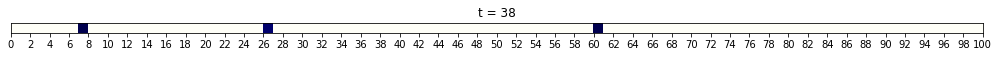

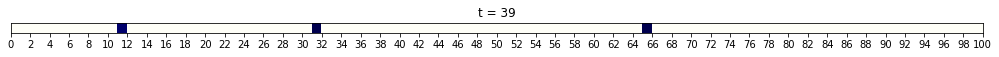

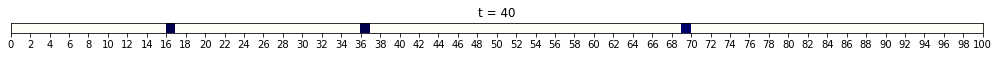

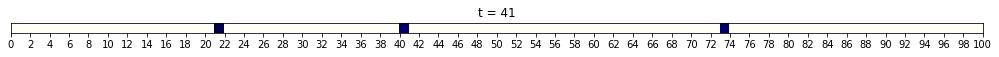

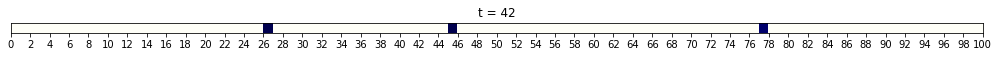

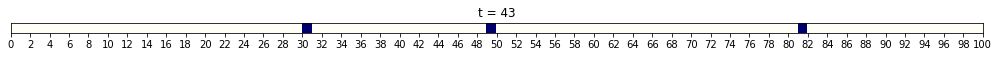

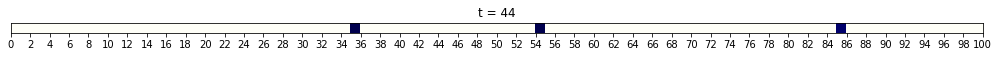

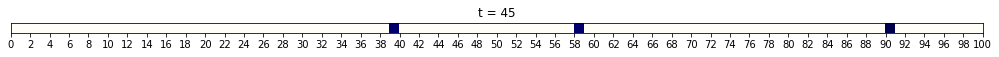

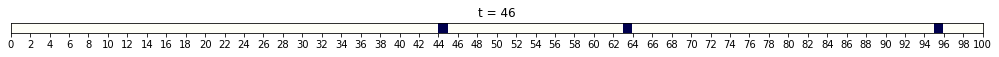

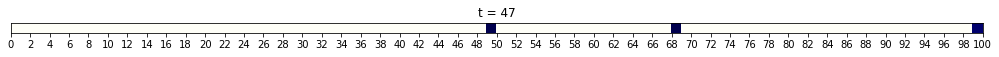

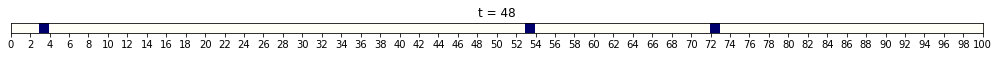

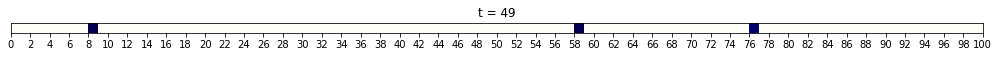

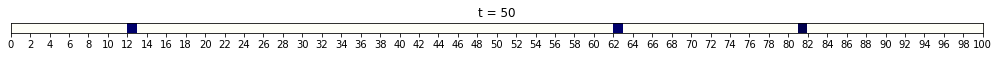

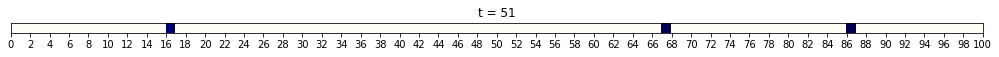

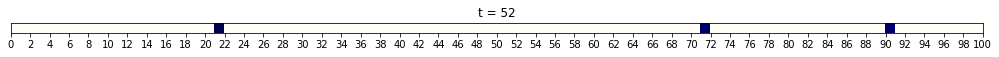

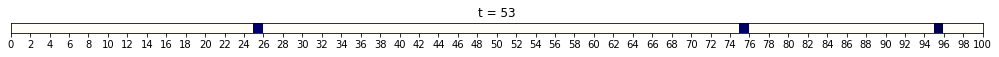

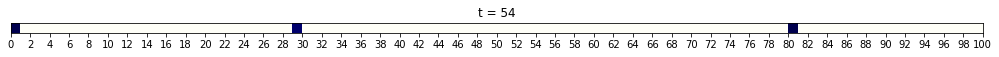

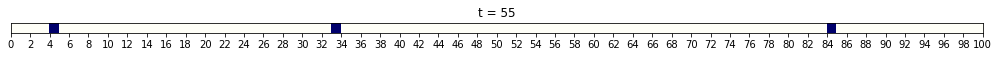

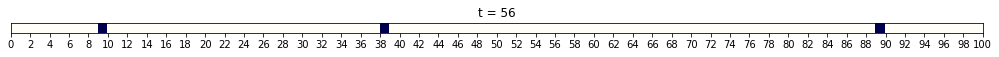

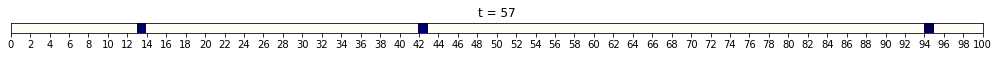

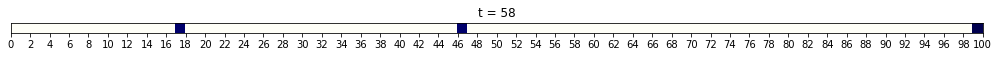

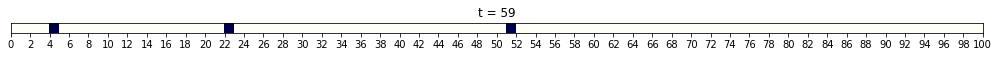

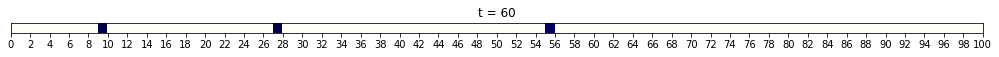

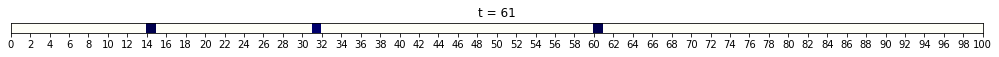

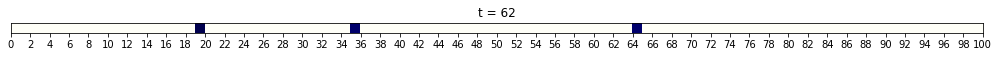

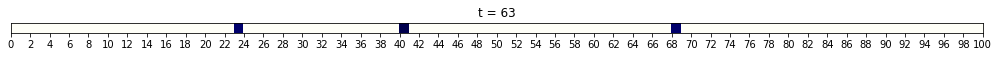

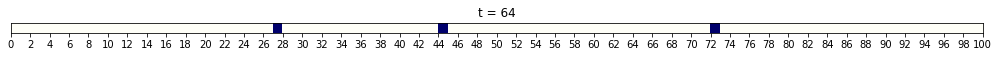

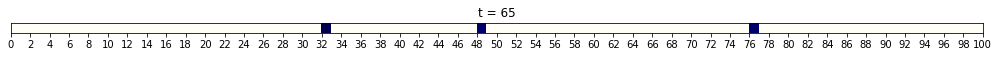

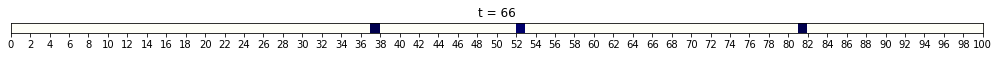

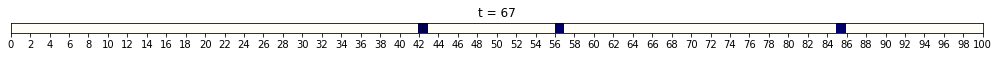

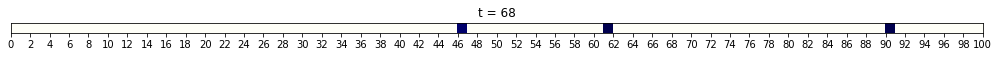

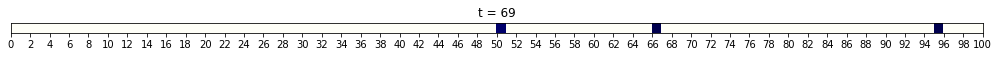

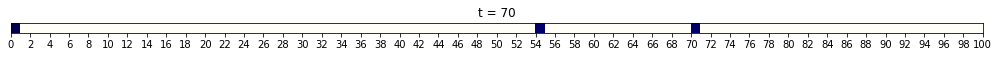

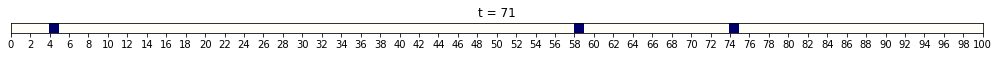

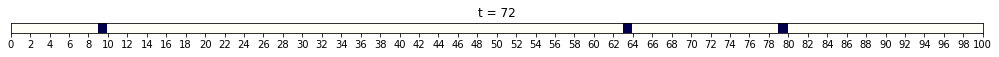

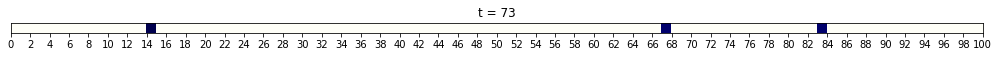

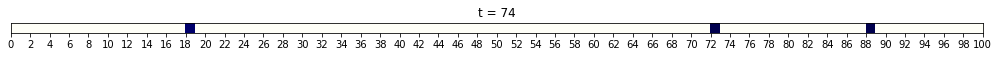

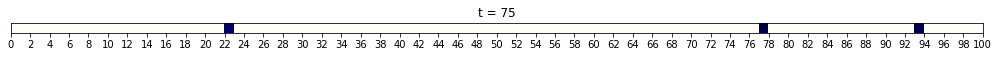

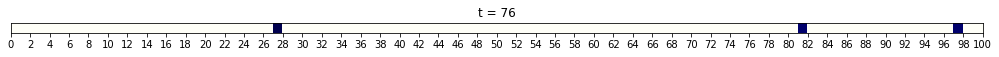

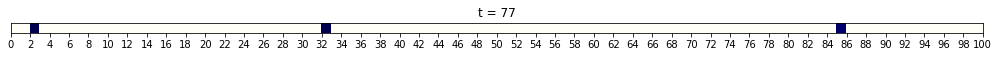

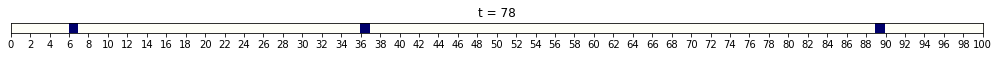

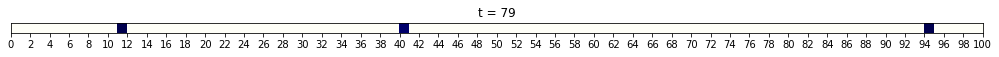

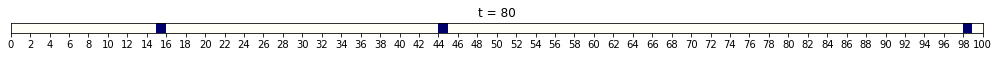

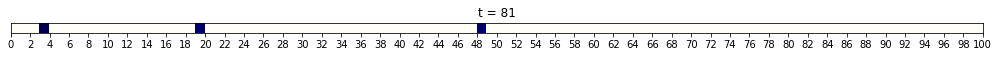

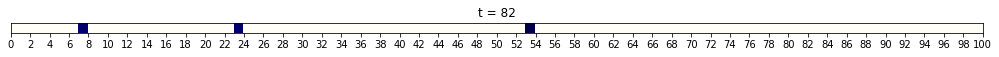

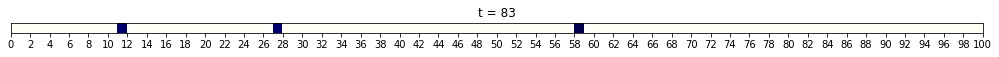

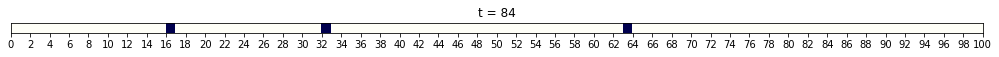

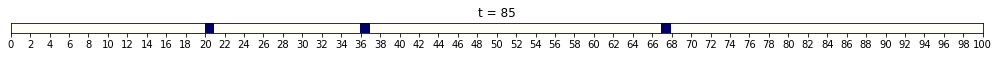

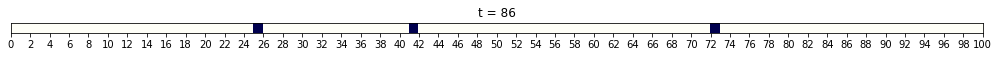

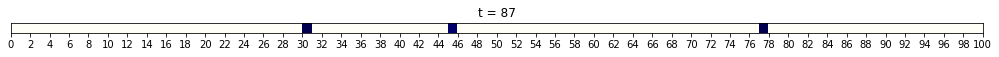

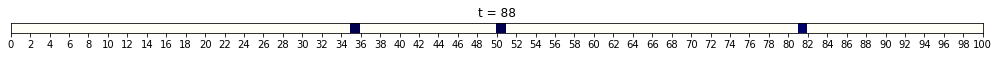

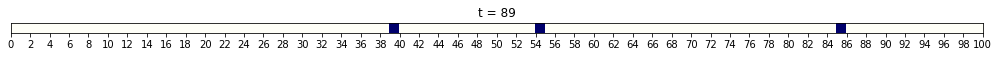

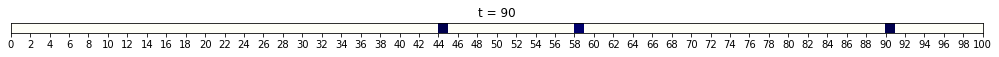

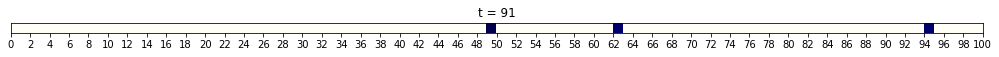

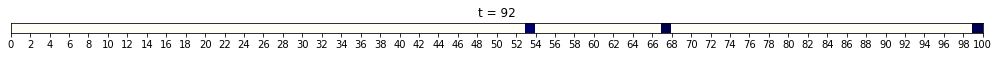

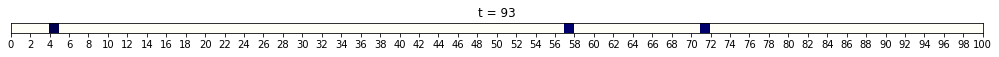

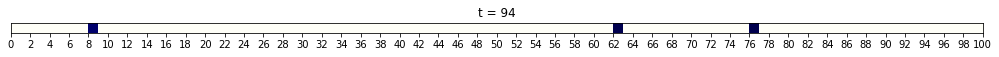

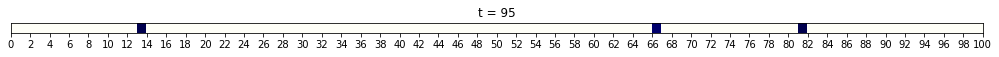

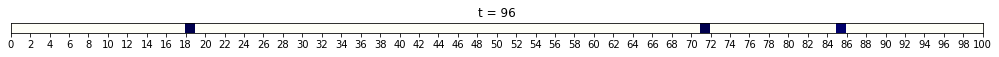

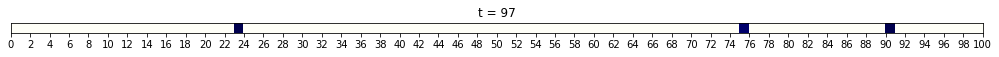

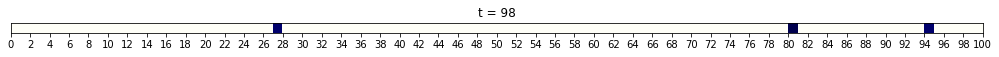

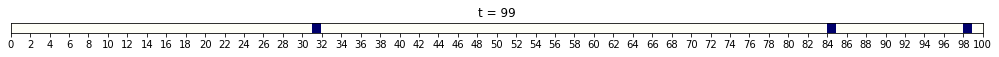

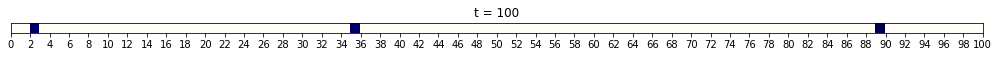

In [818]:
CAsim = TrafficSimulation(size=100,car_density=0.03, p_slow = 0.5)
sim.initialize()
# sim.state = np.array([1, 1, 3, -1, 1, 1, 1, -1, 1, 1])
# print 'Initial states:'
# print('\033[94m' + str(sim.state)+ '\x1b[0m')

sim.draw()

for t in range(100):
    sim.update()
    sim.draw()
#print(pd.DataFrame((sim.state.reshape(-1,len(sim.state)))))

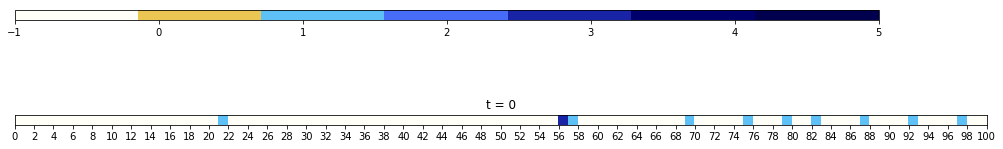

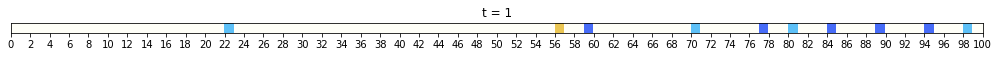

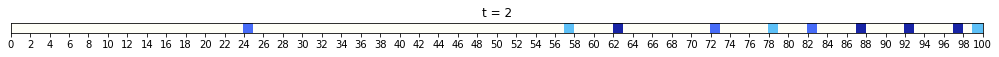

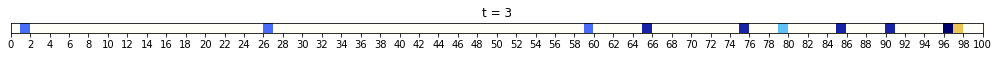

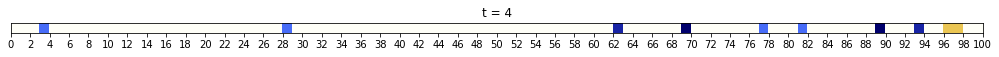

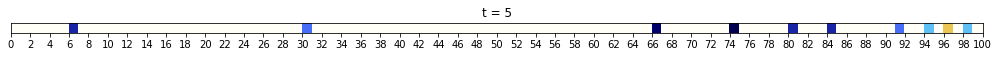

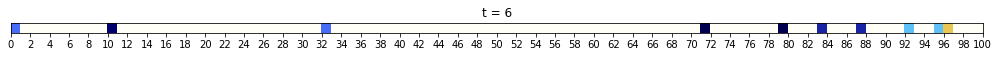

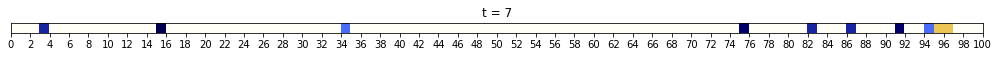

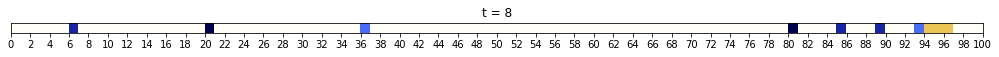

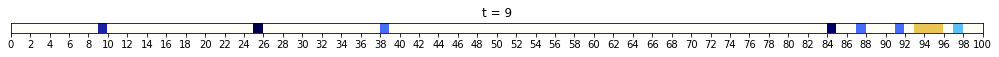

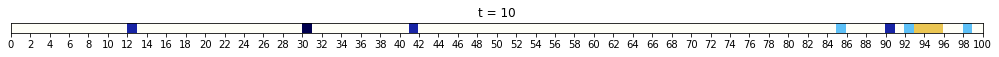

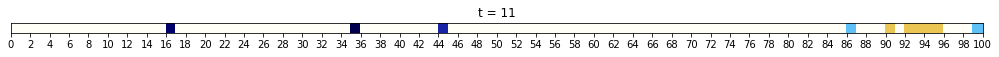

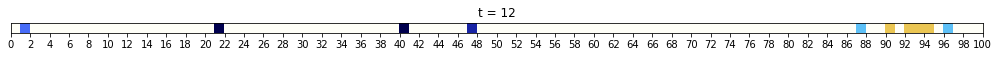

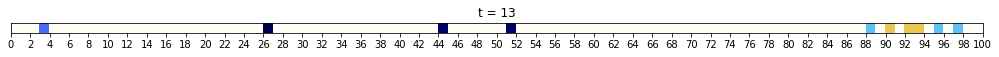

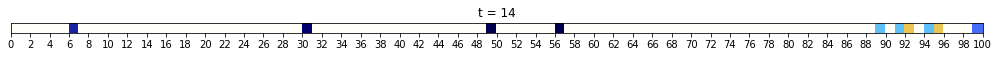

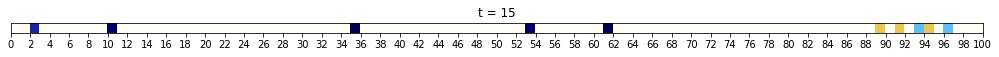

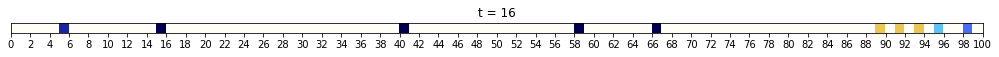

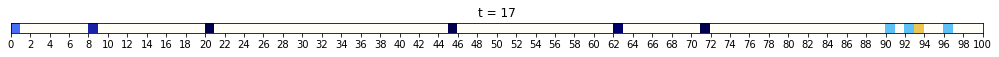

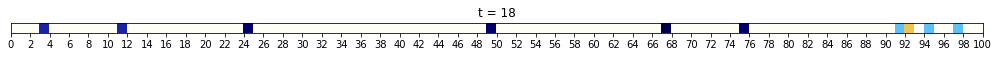

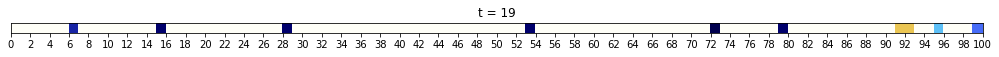

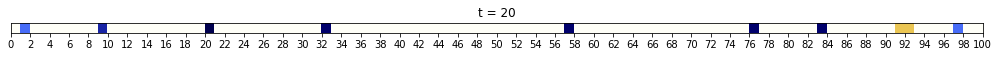

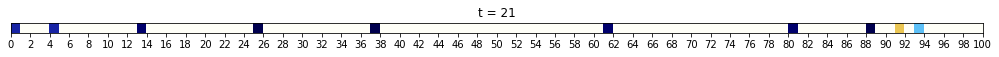

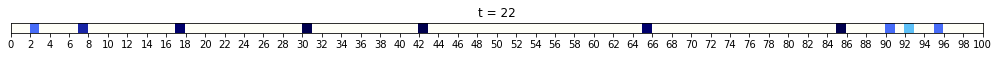

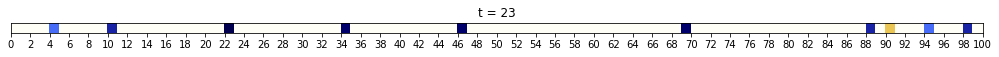

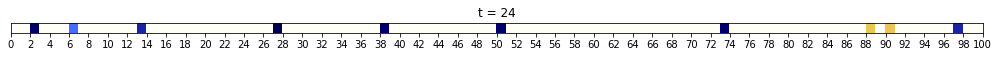

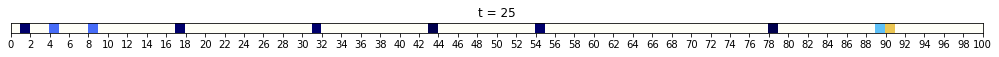

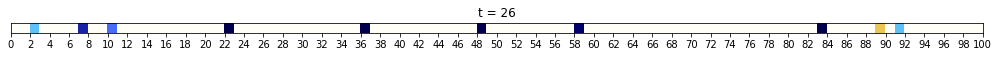

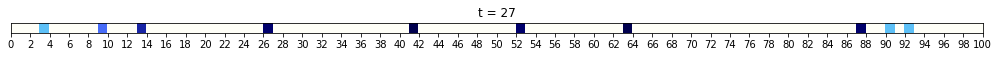

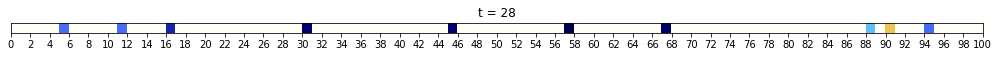

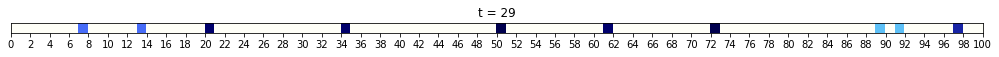

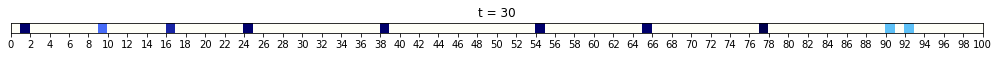

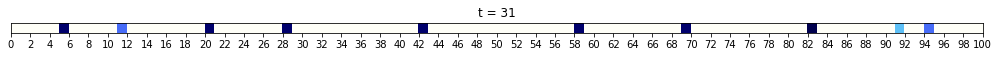

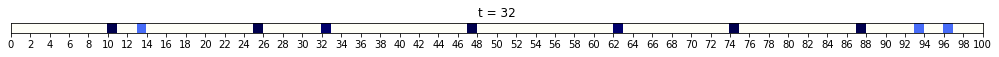

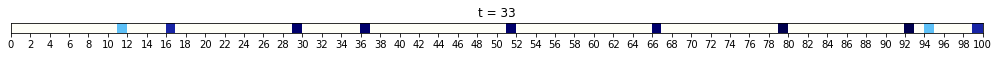

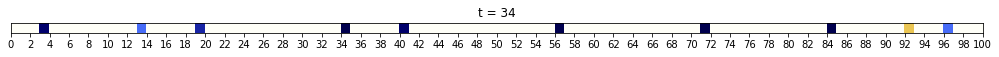

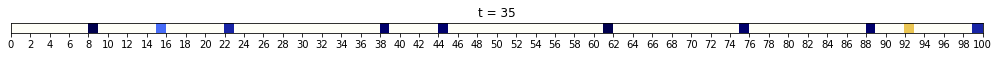

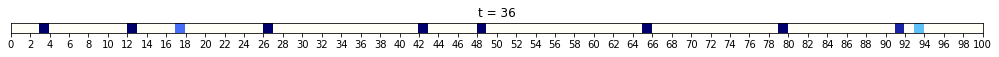

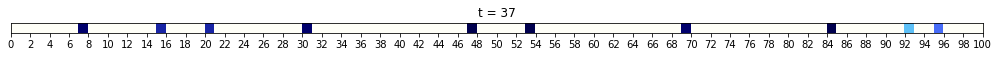

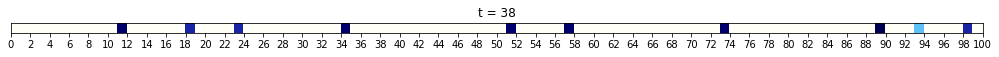

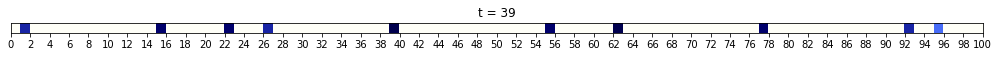

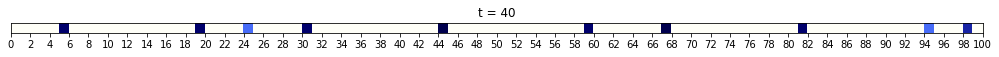

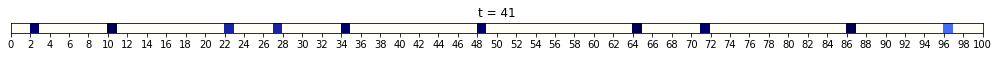

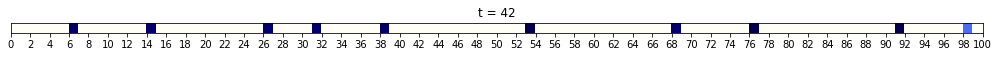

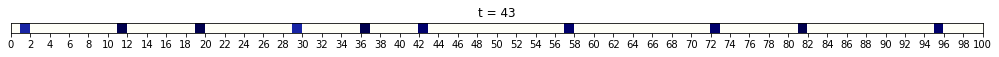

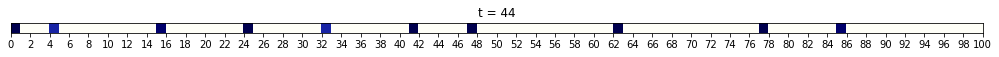

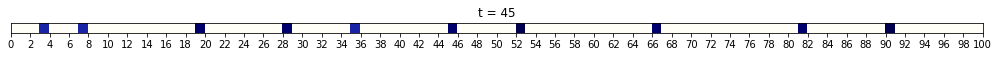

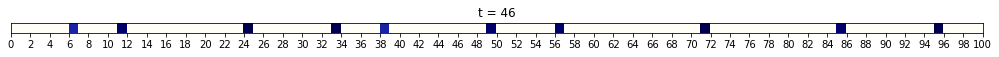

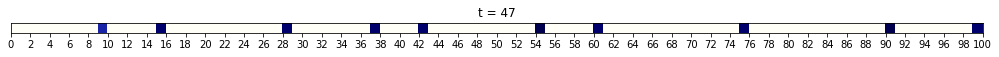

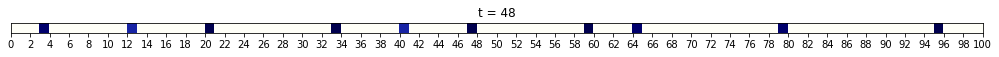

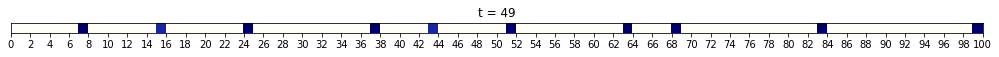

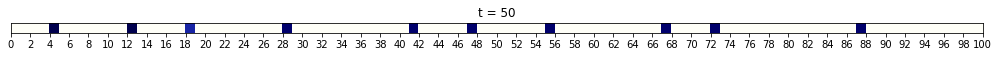

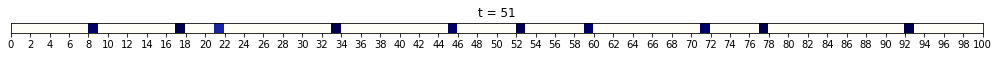

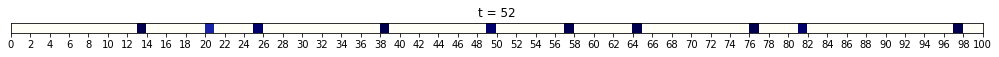

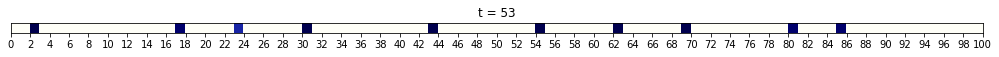

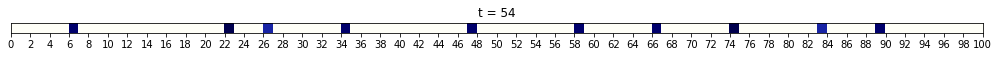

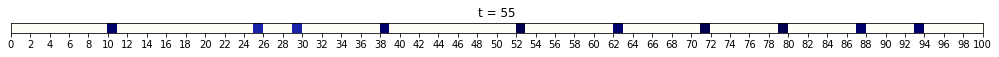

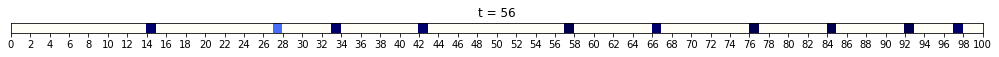

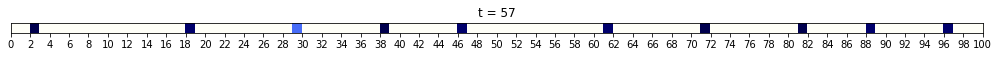

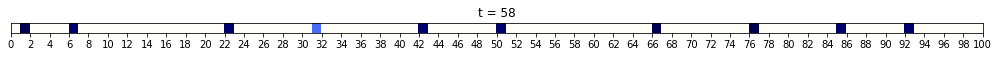

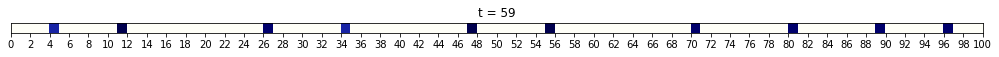

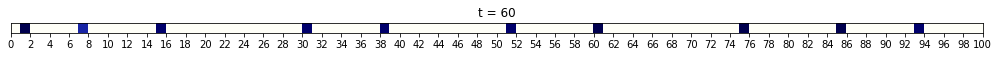

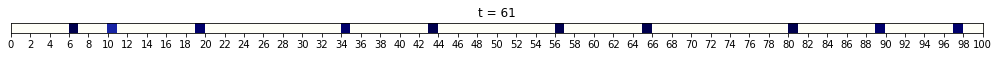

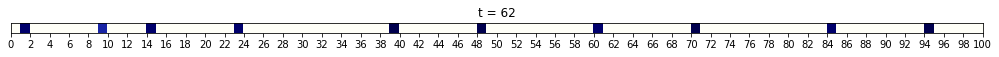

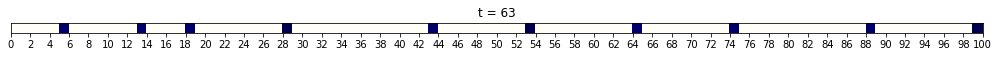

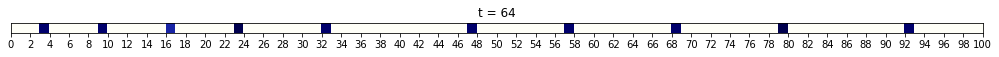

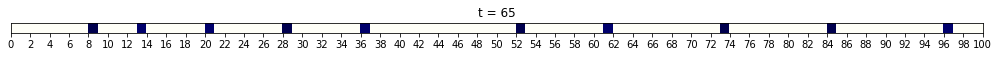

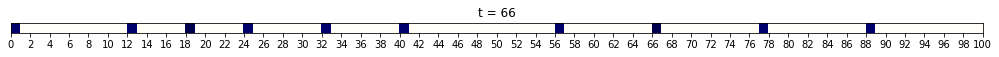

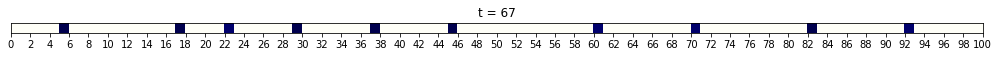

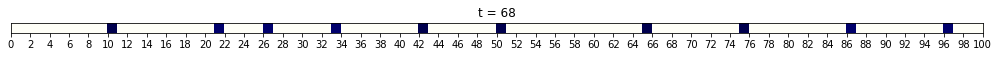

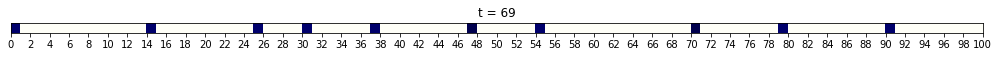

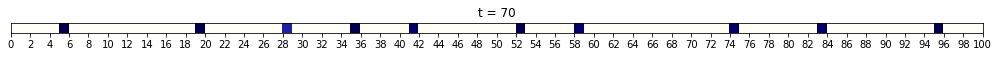

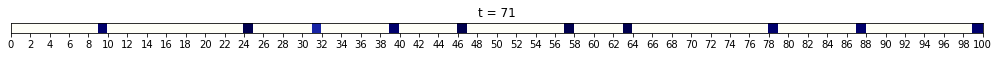

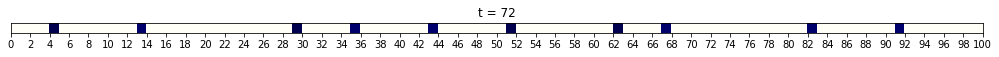

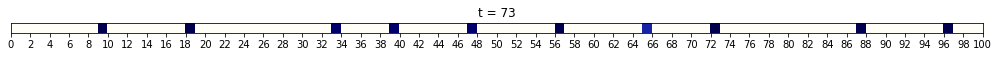

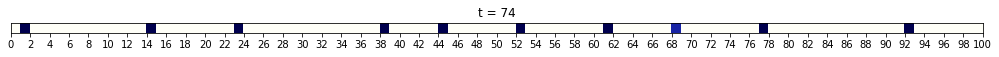

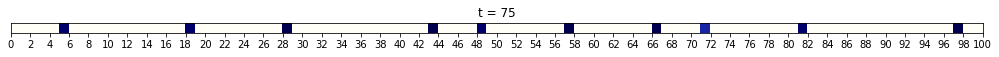

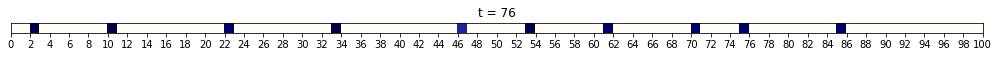

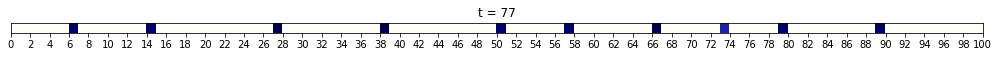

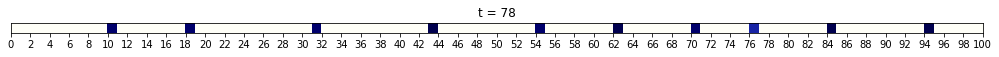

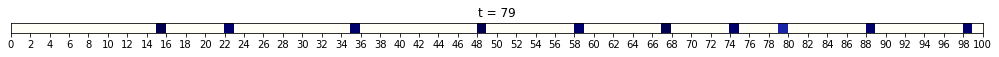

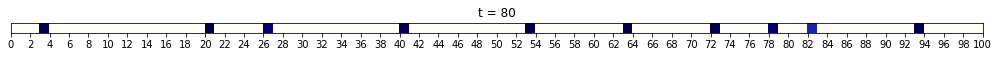

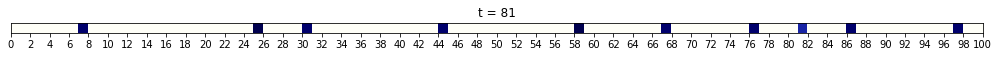

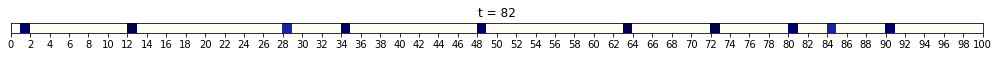

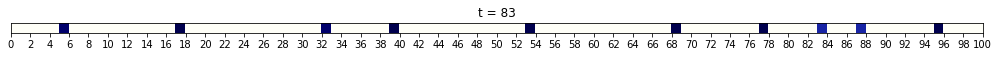

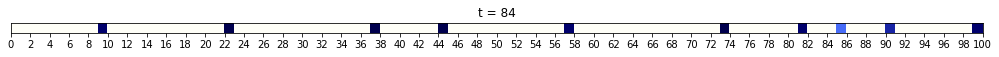

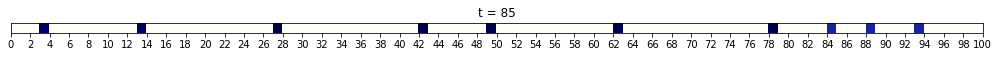

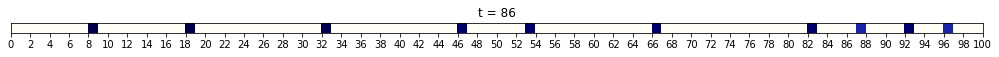

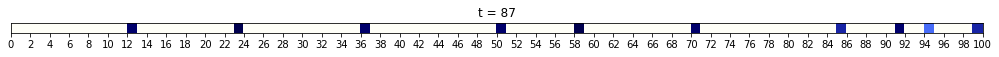

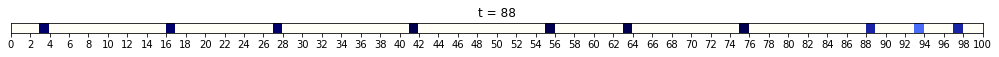

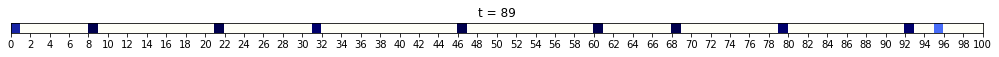

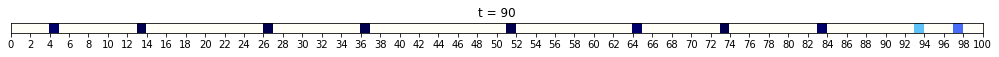

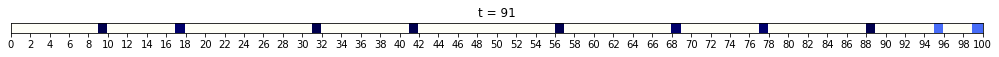

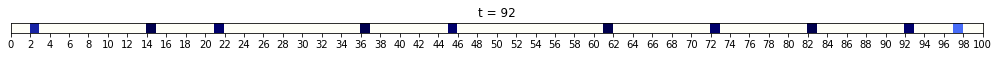

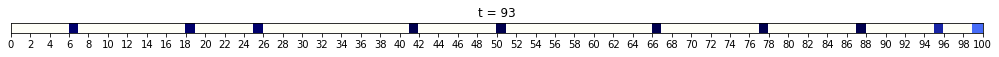

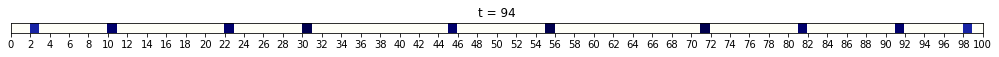

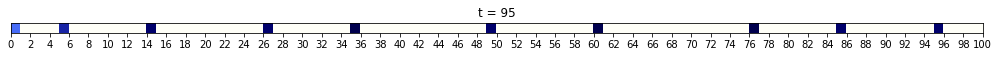

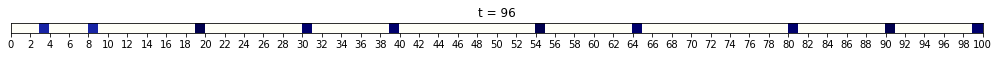

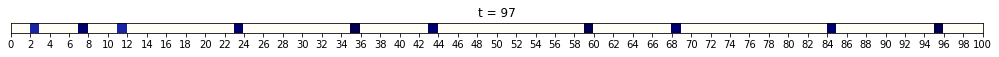

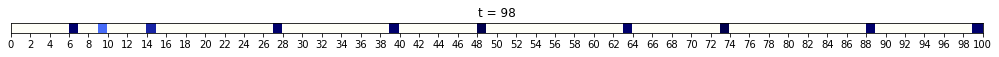

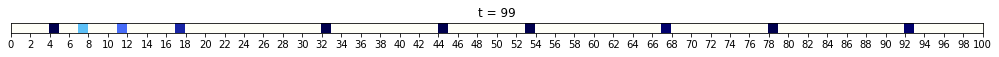

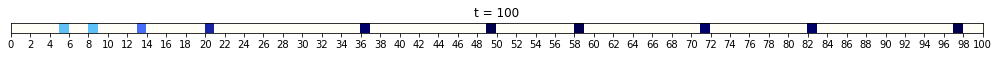

In [819]:
CAsim = TrafficSimulation(size=100,car_density=0.10, p_slow = 0.5)
sim.initialize()
# sim.state = np.array([1, 1, 3, -1, 1, 1, 1, -1, 1, 1])
# print 'Initial states:'
# print('\033[94m' + str(sim.state)+ '\x1b[0m')

sim.draw()

for t in range(100):
    sim.update()
    sim.draw()
#print(pd.DataFrame((sim.state.reshape(-1,len(sim.state)))))

In [820]:
CA# mock_state = np.array([0, 1, 0, 0 , 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,0])

In [821]:
# vmax = 5
# cars = np.where(mock_state > 0)[0]
# print 'cars: '+str(cars)
# next_car = [cars[(i+1)%len(cars)] for i in range(len(cars))]
# print 'next cars: '+str(next_car) 
# post_state = np.zeros(20,dtype=np.int64)

# def car_distance(x,y):
#     if x > y: return x-y
#     else: return len(mock_state) - x + y

# for i,car in enumerate(cars):
#     if mock_state[car] < vmax and car_distance(next_car[i], car) > mock_state[car]+1:
#         mock_state[car] += 1
#     elif car_distance(next_car[i], car) <= mock_state[car] - 1:
#         mock_state[car] = car_distance(next_car[i], car) - 1
    
#     print(mock_state)
    
#     for x in cars:
#         post_state[(x + mock_state[x])%len(mock_state)] = mock_state[x]
    
#     print('\033[94m' + str(post_state)+ '\x1b[0m')
    
# mock_state = post_state
# print mock_state

array([0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])

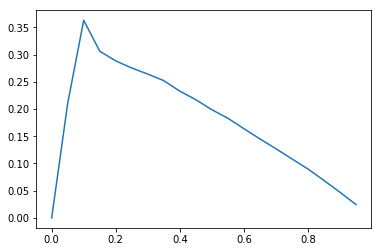

In [886]:
xx, yy   = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(densities, flow) if xVal==a])) for xVal in set(densities)))
[]

In [882]:
type(set(densities))

set